This notebook is for a simple ranking optimisation algorithm based on the ELO model.

By Andrew Soon, 16/06/24

What is ELO?
https://en.wikipedia.org/wiki/Elo_rating_system

Each team has a hidden relative rating R. 

When team A and team B play, the expected result for team A is

EA = (1+ 10^((Ra-Rb)/400)) ^ (-1)

and the expected result for team B is 

EB = (1+ 10^((Rb-Ra)/400)) ^ (-1)

We can expand this to a league of n teams, which have a rating of Ra, Rb, ... Rn respectively.

The expected ELO results can be compared to actual results, with an associated loss function. 

We should be able to find relative values of Ra, Rb, ... Rn which would minimise the expected loss relative to the actual scores. Since ELO is relative, we will not be able to find absolute values.

For example,
Match 1: Team A beats Team B: Actual A = 1, Actual B = 0, versus EA and EB calculated
Match 2: Team C beats Team D: Actual C = 1, Actual D = 0, versus EC and ED calculated
....
Match M: Team A loses to Team D:Actual A = 0, Actual D = 1, versus EA and ED calculated

The Loss function is the summation (of some sorts) of Actual - Expected for all M matches. 

This is useful for a closed league system like the EPL, whereby there are a large number of teams playing double round robin style. This allows for all teams to have some graph relationship very early in the season, which means the possibility for timely and useful predictions.

The goal of this notebook is to annotation down some quick findings when this is applied to EPL season 23/24.

First, some libraries that we will be using. networkx is just useful for the graph function.

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import copy


The dataset can be downloaded from https://www.football-data.co.uk/englandm.php

Season 2023/2024 was selected.

The csv file called E0.csv will be generated, place it in the same folder or change the code to import it.

This function can be changed for different seasons if you wish

In [3]:
def do_inpro():
    df = pd.read_csv('E0.csv')
    pd.set_option('display.max_columns', None)
    columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']
    df = df[columns_to_keep]
    df['HomeTeam'] = df['HomeTeam'].astype(str)
    df['AwayTeam'] = df['AwayTeam'].astype(str)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df['Result'] = df.apply(lambda row: 1 if row['FTHG'] > row['FTAG'] else (0 if row['FTHG'] < row['FTAG'] else 0.5), axis=1)
    # FT= full time, HG = home goals, AG = away goals
    match_dates = df['Date'].unique()
    return df, match_dates


Lets do the whole season first to get a feel of how the ELO optimisation will work, and see if there is any need to adjust certain parameters.

First, a bunch of functions which we will use. Some of the functions look a bit weird at first, but they started out from simulated data before going to actual data:

The core of our model, the probability function. There is some literature out there about home advantage, so we will experiment on it later. Right now, set it to zero.

In [4]:
def get_expected_prob(ra,rb,home_adv = 0):
    expected_prob = (1+ 10 **((rb-ra-home_adv)/400)) ** (-1)
    return expected_prob


The match list we feed into the model needs to be complete. Else, we will end up with isolated pockets or teams not being rated at all.

Right now, this function assumes match lists are fed in a nested list format:
[[team_a, team_b, result],....]

This format is slightly easier to do quick checks on simulated data.

In [5]:
def do_graph_check(match_list):
    """
    this does a check to ensure that all teams are connected in one way or another in the provided match list
    we need true and 20 teams to be returned
    """
    G = nx.Graph()
    # Add edges to the graph, ignoring the third element in each sublist 
    for sublist in match_list:
        a, b, _ = sublist  # Unpack the sublist, ignoring the third element
        G.add_edge(a, b)
    is_connected = nx.number_connected_components(G) == 1
    total_nodes = G.number_of_nodes()
    return is_connected, total_nodes


A simple dictionary will help us keep track of the ELO for each team. 

Once again, it assumes match list is a nested list [[team_a, team_b, result],....]

In [6]:
def get_elo_dict(match_list):
    """
    this function generates a simple dictionary for all teams with a default ELO of 1000
    """
    unique_values = set()

    # Iterate over each sublist
    for sublist in match_list:
        # Extract values at 0th and 1st place
        value_0 = sublist[0]
        value_1 = sublist[1]

        # Add the values to the set
        unique_values.add(value_0)
        unique_values.add(value_1)

    elo_dict = {value: 1000 for value in unique_values}
    return elo_dict


This function will just go over the provided list of matches, and use the ELO to generate a loss value.

After that, it perturbs the states to look for reduction in error if we change the team ELO.

What loss function to use is a matter of choice. After experimenting, using squared errors instead of absolute errors works better for the model to explore the different teams, rather than focusing on the extreme.

Due to the nature of the problem (relative rankings) it is difficult to generate numerical answers. In addition, as the loss function was changing throughout my work, calculating the partials seemed like a waste of effort. Thats why the brute force perturbing algorith was used. 

In [7]:
def do_iteration(elo_dict,match_list):
    """
    runs through all the provided data, generates the current loss function
    does perturbations up and down to see how to lower the loss
    """
    loss_list = []
    delta_list = {}
    delta_list_neg = {}
    for keys,values in elo_dict.items():
        delta_list[keys] = []
        delta_list_neg[keys] = []
    for match_entry in match_list:
        team_a = match_entry[0]
        team_b = match_entry[1]
        result = match_entry[2]
        ra = elo_dict[team_a]
        rb = elo_dict[team_b]
        pred_result = get_expected_prob(ra,rb)
        a_points, b_points = get_points(pred_result)
        loss = (result - pred_result) ** 2
        loss_list.append(loss)
        for keys, values in elo_dict.items():
            loss_delta = do_preturb_sq(team_a, team_b, ra, rb, result, keys, loss, learn_rate)
            temp = delta_list[keys]
            temp.append(loss_delta)
            delta_list[keys] = temp
            loss_delta_neg = do_preturb_sq(team_a, team_b, ra, rb, result, keys, loss, -learn_rate)
            temp = delta_list_neg[keys]
            temp.append(loss_delta_neg)
            delta_list_neg[keys] = temp

    return delta_list,delta_list_neg, loss_list


The ELO values do need to be constrained to an upper limit of 1500 and a lower limit of 900. This stops too extreme ratings from being perferred and allows the model to vary other teams score rather than the extremely high or low values. 

In [8]:
def do_preturb_sq(team_a,team_b,ra,rb,result,team,loss,learn_rate,upper_bound = 1500, lower_bound = 900):
    # widening the bounds allow for more variance
    # closing the bounds stops extreme events
    if team_a == team:
        #ra_delta = ra + 100
        if learn_rate > 0:
            ra_delta = min(upper_bound,ra + learn_rate)
        else:
            ra_delta = max(lower_bound,ra + learn_rate)
        pred_result_del = get_expected_prob(ra_delta, rb)
        loss = (result - pred_result_del) ** 2
    elif team_b == team:
        #rb_delta = rb + 100
        if learn_rate > 0:
            rb_delta = min(upper_bound,rb + learn_rate)
        else:
            rb_delta = max(lower_bound,rb + learn_rate)
        pred_result_del = get_expected_prob(ra, rb_delta)
        loss = (result - pred_result_del) ** 2
    else:
        pass # placeholder
    return loss


Once we have the list of error values to each key, this function looks for the smallest error value

In [9]:
def get_smallest_key(nested_dictionary):
    """
    this function looks for the key having the smallest error
    it will be used for optimisation
    """
    min_sum_key = None
    min_sum = float('inf')

    # Iterate over dictionary items
    for key, value in nested_dictionary.items():
        # Calculate the sum of the list
        current_sum = sum(value)
        # Check if the current sum is less than the minimum sum found so far
        if current_sum < min_sum:
            # Update the minimum sum and the corresponding key
            min_sum = current_sum
            min_sum_key = key

    return nested_dictionary[min_sum_key], min_sum_key


Points in EPL are different to the ELO model. 3 points for a win and 1 for a draw is not congruent with the model, so to estimate final rankings, we need some form of scale. 

Two functions are needed, one to sum existing points up to that time, and the second to do to forecasting.

In [10]:
def get_points(expected_result):
    """
    if expected_result <=0.5:
        a_points = expected_result *3
        b_points = 1.5 + (1 - expected_result - 0.5) * 3
    else:
        a_points = 1.5 + (expected_result - 0.5) * 3
        b_points = (1-expected_result) * 3
    """
    if expected_result <= 0.5:
        a_points = expected_result * 4 / 3 * 2
        b_points = 4/3 + (0.5-expected_result) * (3-4/3)/0.5
    else:
        a_points = 4/3 + (expected_result - 0.5) * (3-4/3)/0.5
        b_points = (1 - expected_result) * 4 / 3 * 2
    #print(expected_result,a_points,b_points)
    return a_points, b_points


In [11]:
def get_existing_points(pre_list,elo_dict):
    """
    this function just tabulates the existing values for each team
    it is useful for projecting data
    """
    new_dict = {key: 0 for key in elo_dict}
    for upcoming_match in pre_list:
        team_a = upcoming_match[0]
        team_b = upcoming_match[1]
        result = upcoming_match[2]
        if result == 1:
            new_dict[team_a] = new_dict[team_a] + 3
        elif result == 0:
            new_dict[team_b] = new_dict[team_b] + 3
        else:
            new_dict[team_a] = new_dict[team_a] + 1
            new_dict[team_b] = new_dict[team_b] + 1
    return new_dict


Lets run through the data in accordance to the ELO model

In [12]:
# begin here
df, match_dates = do_inpro()
learn_rate = 10

train_list = [row[['HomeTeam', 'AwayTeam', 'Result']].tolist() for index, row in df.iterrows()]

is_connected, total_nodes = do_graph_check(train_list)
print(is_connected, total_nodes)

# this makes sure that the data is all connected in one graph. 
# Else the algo will start optimising two separate groups


True 20


In [13]:
elo_dict = get_elo_dict(train_list)

for x1 in range(10000):
    delta_list,delta_list_neg, loss_list = do_iteration(elo_dict,train_list)
    smallest_list,smallest_list_key = get_smallest_key(delta_list)
    smallest_list_neg, smallest_list_key_neg = get_smallest_key(delta_list_neg)
    # try to go up first
    # then go down
    if sum(smallest_list) < sum(loss_list):
        elo_dict[smallest_list_key] = elo_dict[smallest_list_key] + learn_rate
    elif sum(smallest_list_neg) < sum(loss_list):
        elo_dict[smallest_list_key_neg] = elo_dict[smallest_list_key_neg] - learn_rate
        #pass
    else:
        # this section is block commented due to output. IDE users can uncomment
        """
        print(loss_list)
        print(sum(loss_list))
        for key,nest_list in delta_list.items():
            print(key,nest_list, sum(nest_list))
        print(smallest_list, smallest_list_key)
        """
        break

sorted_data = dict(sorted(elo_dict.items(), key=lambda item: item[1], reverse=True))
points_dict = get_existing_points(train_list, elo_dict)
sorted_points = dict(sorted(points_dict.items(), key=lambda item: item[1], reverse=True))


In [14]:
print("the loss value is",sum(loss_list))
print("teams ELO")
for key, value in sorted_data.items():
    print(key,value)


the loss value is 53.53829253462896
teams ELO
Man City 1500
Arsenal 1490
Liverpool 1450
Aston Villa 1340
Chelsea 1320
Tottenham 1310
Man United 1280
Newcastle 1280
West Ham 1240
Brighton 1230
Crystal Palace 1220
Everton 1220
Bournemouth 1220
Fulham 1200
Wolves 1190
Brentford 1160
Nott'm Forest 1130
Burnley 1060
Luton 1050
Sheffield United 950


Not bad, our model actually runs. the comparison is quite in order relative to the actual standings

In [15]:
print("teams actual final points")
for key, value in sorted_points.items():
    print(key,value)

teams actual final points
Man City 91
Arsenal 89
Liverpool 82
Aston Villa 68
Tottenham 66
Chelsea 63
Man United 60
Newcastle 60
West Ham 52
Crystal Palace 49
Brighton 48
Everton 48
Bournemouth 48
Fulham 47
Wolves 46
Brentford 39
Nott'm Forest 36
Luton 26
Burnley 24
Sheffield United 16


first up, lets play around with the home advantage

In [16]:
def get_expected_prob(ra,rb,home_adv = 70):
    expected_prob = (1+ 10 **((rb-ra-home_adv)/400)) ** (-1)
    return expected_prob

In [17]:
elo_dict = get_elo_dict(train_list)

for x1 in range(10000):
    delta_list,delta_list_neg, loss_list = do_iteration(elo_dict,train_list)
    smallest_list,smallest_list_key = get_smallest_key(delta_list)
    smallest_list_neg, smallest_list_key_neg = get_smallest_key(delta_list_neg)
    # try to go up first
    # then go down
    if sum(smallest_list) < sum(loss_list):
        elo_dict[smallest_list_key] = elo_dict[smallest_list_key] + learn_rate
    elif sum(smallest_list_neg) < sum(loss_list):
        elo_dict[smallest_list_key_neg] = elo_dict[smallest_list_key_neg] - learn_rate
        #pass
    else:
        # you can block comment this section if it gets too busy
        """
        print(loss_list)
        print(sum(loss_list))
        for key,nest_list in delta_list.items():
            print(key,nest_list, sum(nest_list))
        print(smallest_list, smallest_list_key)
        """
        break

sorted_data = dict(sorted(elo_dict.items(), key=lambda item: item[1], reverse=True))
points_dict = get_existing_points(train_list, elo_dict)
sorted_points = dict(sorted(points_dict.items(), key=lambda item: item[1], reverse=True))


In [18]:
print("the loss value is",sum(loss_list))
print("teams ELO")
for key, value in sorted_data.items():
    print(key,value)

the loss value is 51.48694702064318
teams ELO
Man City 1500
Arsenal 1500
Liverpool 1450
Aston Villa 1330
Chelsea 1320
Tottenham 1300
Man United 1280
Newcastle 1280
Brighton 1230
West Ham 1230
Everton 1220
Bournemouth 1220
Crystal Palace 1210
Fulham 1190
Wolves 1180
Brentford 1140
Nott'm Forest 1120
Luton 1050
Burnley 1030
Sheffield United 940


In [19]:
print("teams actual final points")
for key, value in sorted_points.items():
    print(key,value)

teams actual final points
Man City 91
Arsenal 89
Liverpool 82
Aston Villa 68
Tottenham 66
Chelsea 63
Man United 60
Newcastle 60
West Ham 52
Crystal Palace 49
Brighton 48
Everton 48
Bournemouth 48
Fulham 47
Wolves 46
Brentford 39
Nott'm Forest 36
Luton 26
Burnley 24
Sheffield United 16


Turns out adding a home advantage makes the model more accurate.

I played around with a few values before settling on 70 as it seemed to have the most reduction.

So we will just use 70 for now. You could bootstrap for a more effective number, but it is better to be roughly right in this model than precisely wrong. Other seasons may have different numbers as well.

Now to do our normal train / test for a time series data set.

Progressively throughout the season, we will calculated the expected ELO for each team up to that point, and use it to forecast the points for the remainder.

Some functions:

In [20]:
def do_forecast(elo_dict,test_list, points_dict):
    loss_list = []
    for upcoming_match in test_list:
        team_a = upcoming_match[0]
        team_b = upcoming_match[1]
        result = upcoming_match[2]
        ra = elo_dict[team_a]
        rb = elo_dict[team_b]
        pred_result = get_expected_prob(ra,rb)

        a_points, b_points = get_points(pred_result)
        points_dict[team_a] = points_dict[team_a] + a_points
        points_dict[team_b] = points_dict[team_b] + b_points
        loss = (result - pred_result) ** 2
        loss_list.append(loss)
    return loss_list, points_dict


In [21]:
def get_existing_points(pre_list,elo_dict):
    new_dict = {key: 0 for key in elo_dict}
    for upcoming_match in pre_list:
        team_a = upcoming_match[0]
        team_b = upcoming_match[1]
        result = upcoming_match[2]
        if result == 1:
            new_dict[team_a] = new_dict[team_a] + 3
        elif result == 0:
            new_dict[team_b] = new_dict[team_b] + 3
        else:
            new_dict[team_a] = new_dict[team_a] + 1
            new_dict[team_b] = new_dict[team_b] + 1
    return new_dict



this code block will take time to run. 

it iterates over all the match dates, performs ELO estimates.

then forecasts the points based on the upcoming fixture list.

In [22]:
mega_ELO = {}
mega_points = {}

for match_date in match_dates:

    before_date = df[df['Date'] < match_date]
    post_date =  df[df['Date'] >= match_date]

    train_list = [row[['HomeTeam', 'AwayTeam', 'Result']].tolist() for index, row in before_date.iterrows()]
    test_list = [row[['HomeTeam', 'AwayTeam', 'Result']].tolist() for index, row in post_date.iterrows()]

    is_connected, total_nodes = do_graph_check(train_list)

    if is_connected == True and total_nodes >= 20:

        elo_dict = get_elo_dict(train_list)

        for x1 in range(10000):
            delta_list,delta_list_neg, loss_list= do_iteration(elo_dict,train_list)
            smallest_list,smallest_list_key = get_smallest_key(delta_list)
            smallest_list_neg, smallest_list_key_neg = get_smallest_key(delta_list_neg)
            # try to go up first
            # then go down
            if sum(smallest_list) < sum(loss_list):
                elo_dict[smallest_list_key] = elo_dict[smallest_list_key] + learn_rate
            elif sum(smallest_list_neg) < sum(loss_list):
                elo_dict[smallest_list_key_neg] = elo_dict[smallest_list_key_neg] - learn_rate
                #pass
            else:
                """
                print(loss_list)
                print(sum(loss_list))
                for key,nest_list in delta_list.items():
                    print(key,nest_list, sum(nest_list))
                print(smallest_list, smallest_list_key)
                """
                break

        points_dict = get_existing_points(train_list, elo_dict)
        loss_list, points_dict = do_forecast(elo_dict,test_list, points_dict)
        #ppg_dict = get_existing_ppg(train_list, elo_dict)

        mega_ELO[match_date] = elo_dict
        mega_points[match_date] = points_dict

Time to visualise the results! We write some quick functions to translate the dictionaries into a format which matplotlib can understand.

In [23]:
def plot_team_points(data):
    teams = {}
    dates = list(data.keys())

    # Extract team names
    for date, match in data.items():
        for team in match.keys():
            if team not in teams:
                teams[team] = []

    # Initialize points for each team
    for team in teams.keys():
        teams[team] = [0] * len(dates)

    # Fill in the points
    for i, date in enumerate(dates):
        match = data[date]
        for team, points in match.items():
            teams[team][i] = points

    plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
    # Plot
    for team, points in teams.items():
        plt.plot(dates, points, label=team)

    #plt.figure()
    plt.xlabel('Date')
    plt.ylabel('Points')
    plt.title('Team Points Over Time')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show(block=True)


In [24]:
def plot_team_ELO(data):
    teams = {}
    dates = list(data.keys())

    # Extract team names
    for date, match in data.items():
        for team in match.keys():
            if team not in teams:
                teams[team] = []

    # Initialize points for each team
    for team in teams.keys():
        teams[team] = [0] * len(dates)

    # Fill in the points
    for i, date in enumerate(dates):
        match = data[date]
        for team, points in match.items():
            teams[team][i] = points

    plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
    # Plot
    for team, points in list(teams.items())[:10]:
        plt.plot(dates, points, label=team)

    plt.xlabel('Date')
    plt.ylabel('ELO')
    plt.title('Estimated Ranking Over Time (Teams 1-10)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot the second graph with the next 10 teams
    plt.figure(figsize=(12, 8))
    for team, points in list(teams.items())[10:]:
        plt.plot(dates, points, label=team)

    plt.xlabel('Date')
    plt.ylabel('ELO')
    plt.title('Estimated Ranking Over Time (Teams 11-20)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


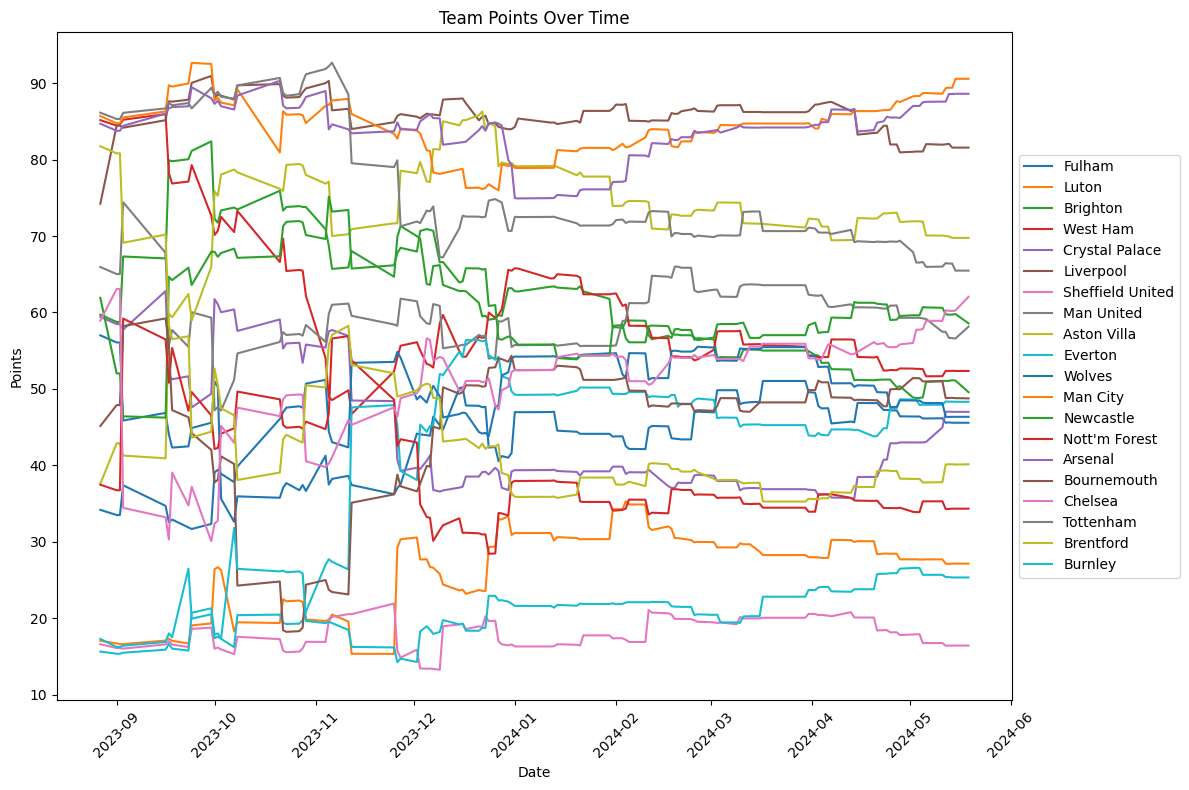

In [25]:
plot_team_points(mega_points)

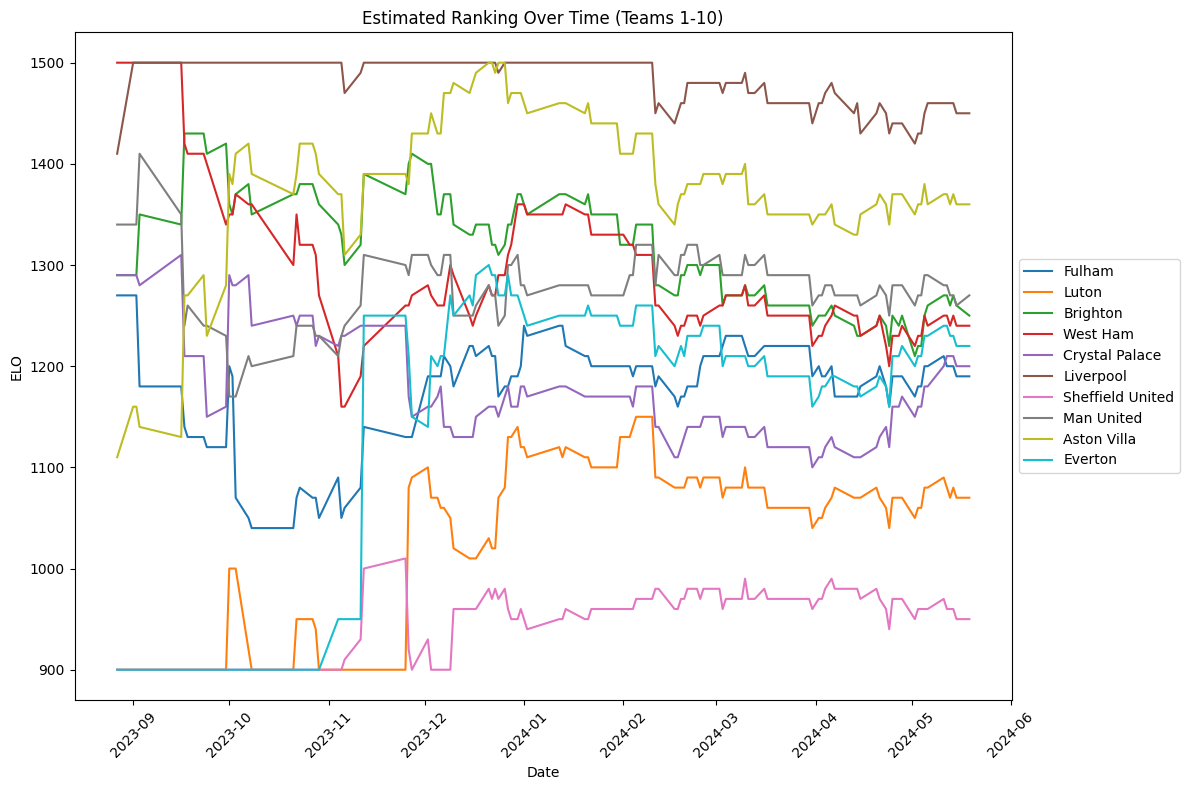

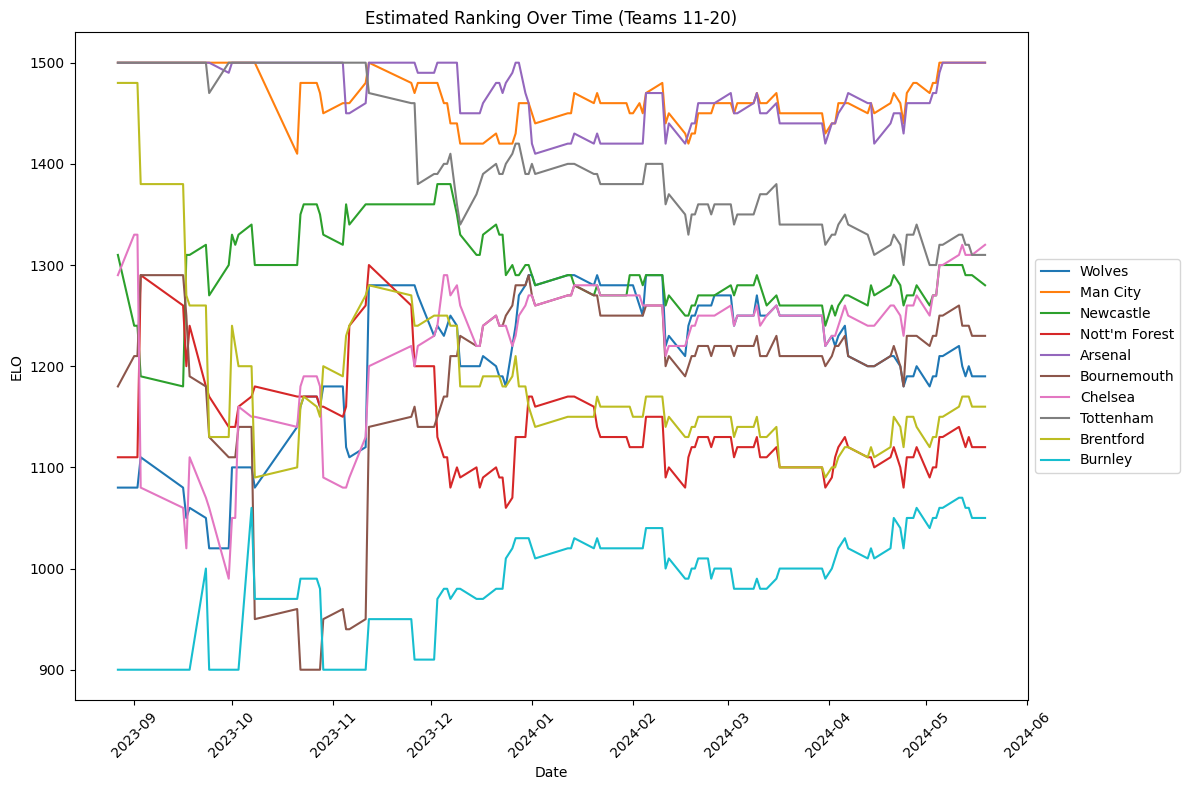

In [26]:
plot_team_ELO(mega_ELO)

However, we have made an assumption of stationary in our work above. Looking at the results, it does not necessarily seem to be true.

So lets do this based on a window. For ease, train data is a 2 month rolling window prior to the date. The EPL takes breaks and we need a minimum number of matches.

For a comparison, we can also include a naive estimator based solely upon the average points achieved by the team in that window, and use it to extrapolate as well. 

In [27]:
def get_existing_ppg(pre_list,elo_dict):
    new_dict = {key: 0 for key in elo_dict}
    match_dict = {key: 0 for key in elo_dict}
    for upcoming_match in pre_list:
        team_a = upcoming_match[0]
        team_b = upcoming_match[1]
        result = upcoming_match[2]
        if result == 1:
            new_dict[team_a] = new_dict[team_a] + 3
        elif result == 0:
            new_dict[team_b] = new_dict[team_b] + 3
        else:
            new_dict[team_a] = new_dict[team_a] + 1
            new_dict[team_b] = new_dict[team_b] + 1
        match_dict[team_a] = match_dict[team_a] + 1
        match_dict[team_b] = match_dict[team_b] + 1
    for key, value in new_dict.items():
        new_dict[key] = new_dict[key] / match_dict[key]
    return new_dict


In [28]:
def do_forecast_ppg(points_dict,test_list, ppg_dict):
    for upcoming_match in test_list:
        team_a = upcoming_match[0]
        team_b = upcoming_match[1]
        points_dict[team_a] = points_dict[team_a] + ppg_dict[team_a]
        points_dict[team_b] = points_dict[team_b] + ppg_dict[team_b]
    return points_dict


In [29]:
mega_ELO_mom = {}
mega_points_mom = {}
mega_points_naive = {}

for match_date in match_dates:
    start_date = match_date - pd.DateOffset(months=2)

    before_date = df[df['Date'] < match_date]
    pre_date = df[(df['Date'] < match_date) & (df['Date'] >= start_date)]
    post_date =  df[df['Date'] >= match_date]

    pre_list = [row[['HomeTeam', 'AwayTeam', 'Result']].tolist() for index, row in before_date.iterrows()]
    train_list = [row[['HomeTeam', 'AwayTeam', 'Result']].tolist() for index, row in pre_date.iterrows()]
    test_list = [row[['HomeTeam', 'AwayTeam', 'Result']].tolist() for index, row in post_date.iterrows()]

    is_connected, total_nodes = do_graph_check(train_list)
    #print(is_connected, total_nodes)

    if is_connected == True and total_nodes >= 20:

        elo_dict = get_elo_dict(train_list)

        for x1 in range(10000):
            delta_list,delta_list_neg, loss_list = do_iteration(elo_dict,train_list)
            smallest_list,smallest_list_key = get_smallest_key(delta_list)
            smallest_list_neg, smallest_list_key_neg = get_smallest_key(delta_list_neg)
            if sum(smallest_list) < sum(loss_list):
                elo_dict[smallest_list_key] = elo_dict[smallest_list_key] + learn_rate
            elif sum(smallest_list_neg) < sum(loss_list):
                elo_dict[smallest_list_key_neg] = elo_dict[smallest_list_key_neg] - learn_rate
                #pass
            else:
                """
                print(loss_list)
                print(sum(loss_list))
                for key,nest_list in delta_list.items():
                    print(key,nest_list, sum(nest_list))
                print(smallest_list, smallest_list_key)
                """
                break

        points_dict = get_existing_points(pre_list, elo_dict)
        points_dict_2 = copy.deepcopy(points_dict)
        ppg_dict = get_existing_ppg(pre_list, elo_dict)
        #points_dict_all = get_existing_points(pre_list, elo_dict) # copy deep copy instead
        # here we need the new ELO DICT based on all matches
        loss_list, points_dict = do_forecast(elo_dict,test_list, points_dict)
        points_dict_2 = do_forecast_ppg(points_dict_2, test_list, ppg_dict)


        mega_ELO_mom[match_date] = elo_dict
        mega_points_mom[match_date] = points_dict
        mega_points_naive[match_date] = points_dict_2


Visualise the results

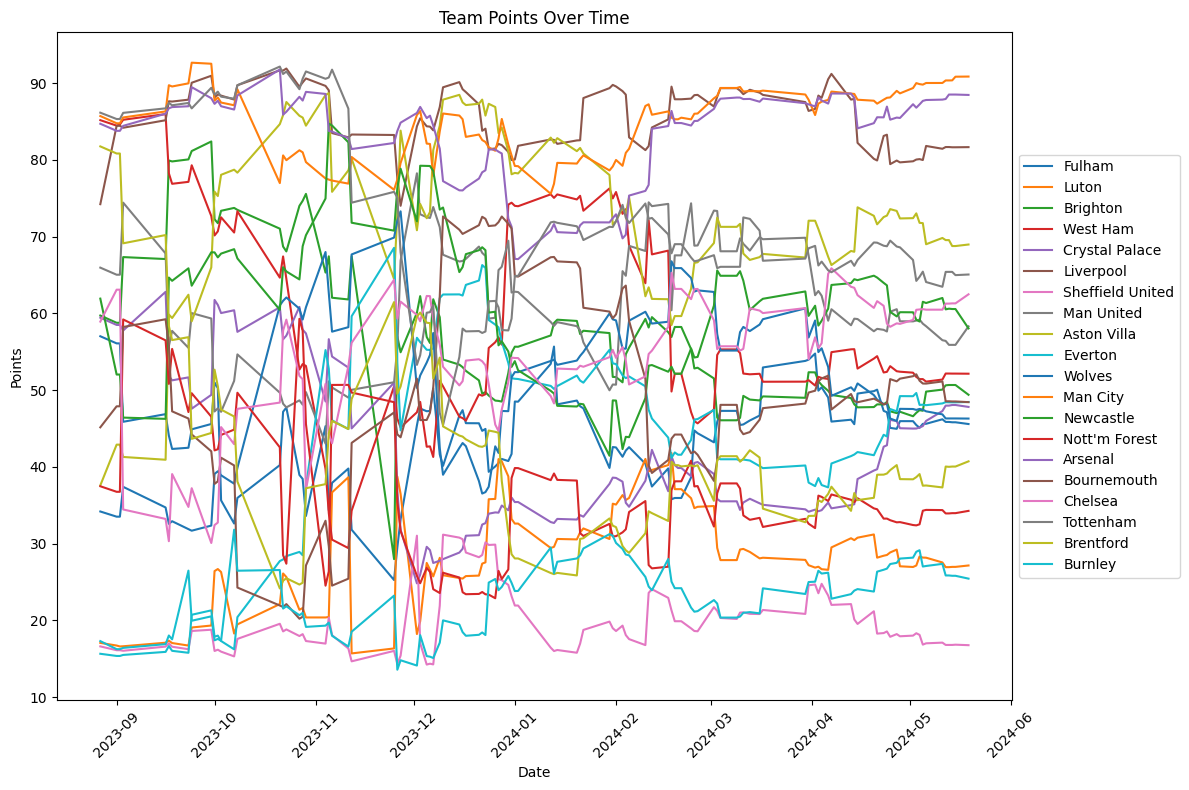

In [30]:
plot_team_points(mega_points_mom)

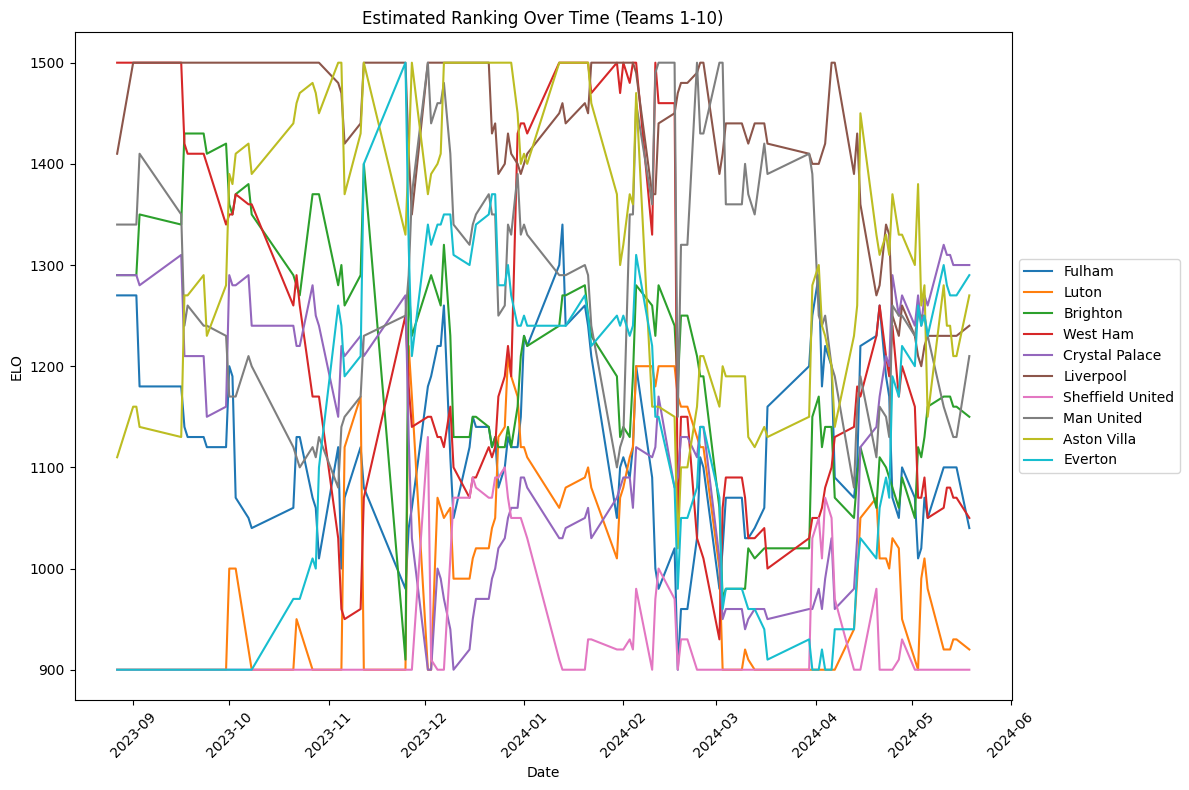

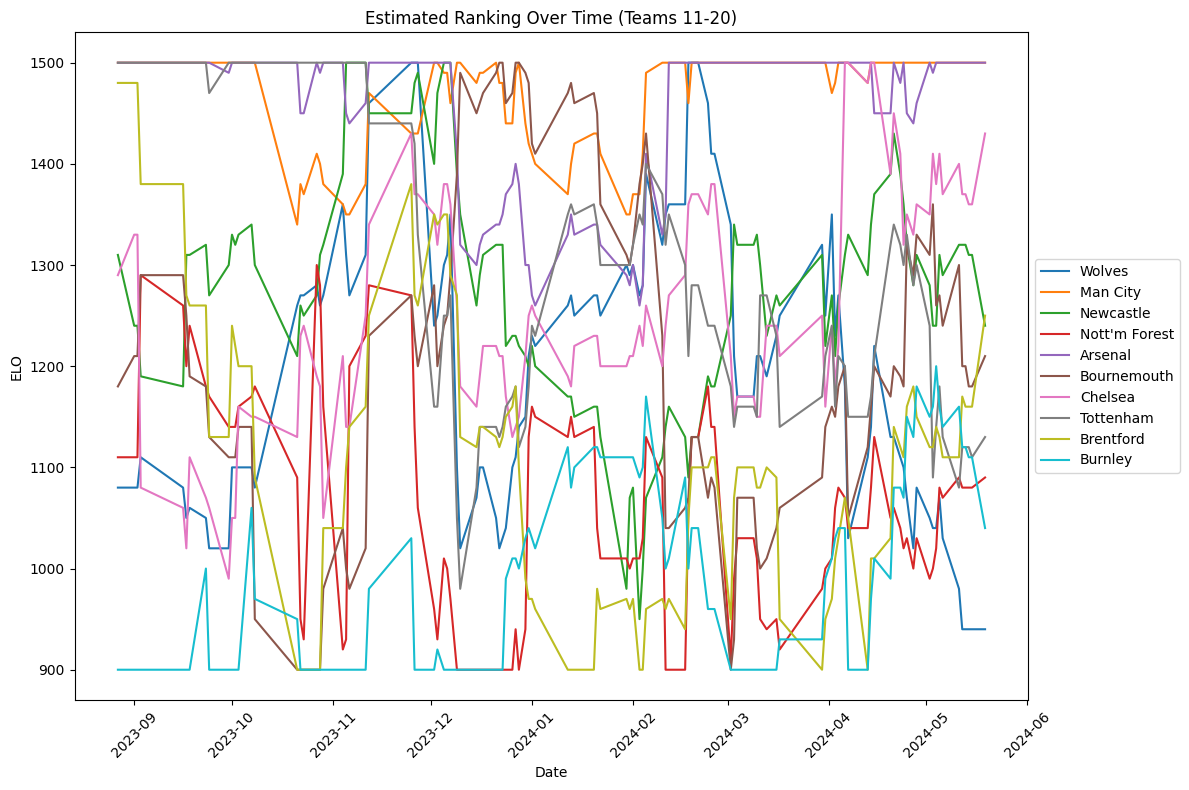

In [31]:
plot_team_ELO(mega_ELO_mom)

It looks like non-stationary is true for the dataset. Many teams flucate based on the two month window relative performance. 

However, its not easy to see the trends for each team. Lets write a quick function to rectify this, and then plot some sample results

In [36]:
def plot_team_points_over_time(team_name, dict1, dict2,dict3):
    # Extract dates from both dictionaries (assuming dates are consistent in both dicts)
    dates = sorted(dict1.keys())  # Sort dates in ascending order

    # Initialize lists to store points for the specified team from both dictionaries
    points_dict1 = []
    points_dict2 = []
    points_dict3 = []

    # Extract points for the specified team from dict1 and dict2
    for date in dates:
        if team_name in dict1[date]:
            points_dict1.append(dict1[date][team_name])
        else:
            points_dict1.append(None)  # Handle missing data gracefully
        if team_name in dict2[date]:
            points_dict2.append(dict2[date][team_name])
        else:
            points_dict2.append(None)  # Handle missing data gracefully
        if team_name in dict3[date]:
            points_dict3.append(dict3[date][team_name])
        else:
            points_dict3.append(None)  # Handle missing data gracefully

    # Plotting the specified team's points over time from both dictionaries
    plt.plot(dates, points_dict1, label=f'ELO_Whole_Season - {team_name}', linestyle='-', marker='o')
    plt.plot(dates, points_dict2, label=f'ELO_2_month - {team_name}', linestyle='--', marker='x')
    plt.plot(dates, points_dict3, label=f'Naive_2_month - {team_name}', linestyle='-.', marker='s')

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Points')
    plt.title(f'{team_name} Points Over Time')
    plt.xticks(rotation=45)
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show(block=True)


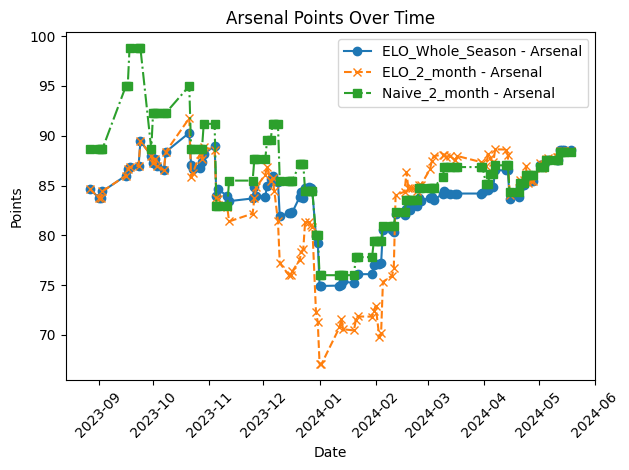

In [37]:
team_name_to_plot = 'Arsenal'
plot_team_points_over_time(team_name_to_plot, mega_points, mega_points_mom, mega_points_naive)


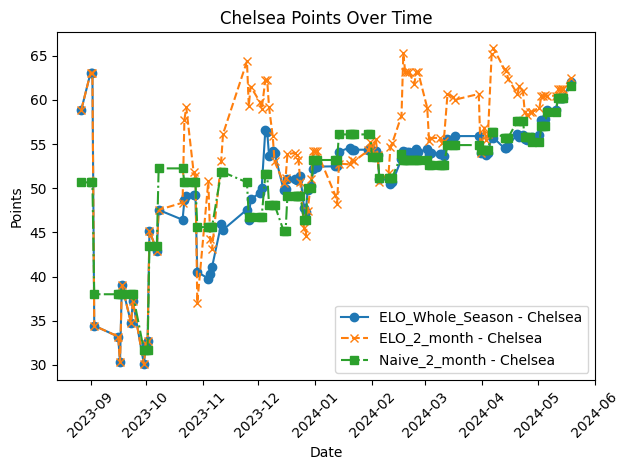

In [38]:
team_name_to_plot = 'Chelsea'
plot_team_points_over_time(team_name_to_plot, mega_points, mega_points_mom, mega_points_naive)


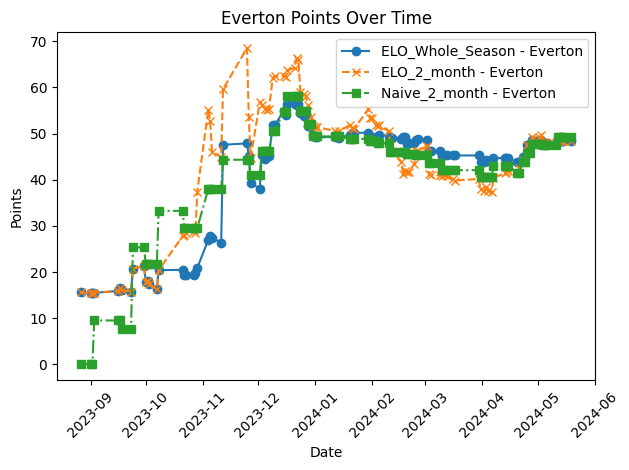

In [39]:
team_name_to_plot = 'Everton'
plot_team_points_over_time(team_name_to_plot, mega_points, mega_points_mom, mega_points_naive)


What can we say about this?

The ELO model seems to be a lot more accurate in determining that something has changed within the team.

The ELO model is also less extreme in the initial phases of the season, due to its constraints on the upper and lower bounds of the points. 

However, it is not necessarily better than the naive model at predicting the eventual end result.

This is a natural cause if the team's relative ELO is non-stationary over time. No model can accurately predict the end result unless they have a separate model of the underlying factors driving the stationary result.

Some factors regarding the team's performance:players change (injuried, bought, sold), coaches change as well (tactics, morale).

How much more can this model run? 

The ELO model is quite limited, but does provide additional context which is missing from naive indicators like W/L/D extrapolation. It gives some context regarding performance should there be an underlying change (eg key player injury). So, if we expect a reversal of the underlying change at a particular point, the model can handle this change. 

The model is hampered by ignoring several pieces of information present in the match, eg goals scored/conceded, halftime score, bookie odds (pre-match estimation). 

It could serve as a more useful contextual evaluation for a team, if other variables are included. 
